# Set up libraries

In [2]:
import pandas as pd
import numpy as np

import requests
from io import StringIO

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import statsmodels.api as sm
from scipy.stats import ttest_ind
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import timedelta
import pmdarima as pm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
import lightgbm as lgb

from joblib import dump

ModuleNotFoundError: No module named 'pandas'

In [4]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.", category=UserWarning)
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge.", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found.", category=UserWarning)
warnings.filterwarnings('ignore')

# Load Data

In [5]:
calls = pd.read_csv('/Users/pendovka/Desktop/Data/Central Intake Service Queue Data.csv')
calls['Date'] = pd.to_datetime(calls['Date'])
calls.set_index('Date', inplace=True)  

calls = calls.rename(columns={'Unmatched callers' : 'unmatched_callers'})

In [6]:
shelter_flow = pd.read_csv('/Users/pendovka/Desktop/Data/toronto-shelter-system-flow.csv')
shelter_flow.rename(columns={'date(mmm-yy)': 'Date'}, inplace=True)
shelter_flow['Date'] = pd.to_datetime(shelter_flow['Date'], format='%b-%y')
shelter_flow = shelter_flow.set_index('Date')

In [7]:
calls_full = pd.read_csv('/Users/pendovka/Desktop/Data/Central Intake Call Wrap-Up Codes Data.csv')
calls_full['Date'] = pd.to_datetime(calls_full['Date'])
calls_full.set_index('Date', inplace=True)
calls_full.rename(columns={'Code 3B - Shelter Space Unavailable - Individuals/Couples': 'shelter_unavailable_ind'}, inplace=True)
calls_full.rename(columns={'Total calls handled': 'total_calls_handled'}, inplace=True)

In [8]:
weather20 = pd.read_csv('/Users/pendovka/Desktop/Data/toronto_weather_20.csv')
weather21 = pd.read_csv('/Users/pendovka/Desktop/Data/toronto_weather_21.csv')
weather22 = pd.read_csv('/Users/pendovka/Desktop/Data/toronto_weather_22.csv')
weather23 = pd.read_csv('/Users/pendovka/Desktop/Data/toronto_weather_23.csv')

weather = pd.concat([weather20, weather21, weather22, weather23])

weather = weather.rename(columns={'Date/Time': 'Date', 'Min Temp (°C)': 'min_temp_cels', 'Total Precip (mm)': 'total_precip_mm'})

weather['Date'] = pd.to_datetime(weather['Date']) 
weather.set_index('Date', inplace=True)

weather = weather[['min_temp_cels', 'total_precip_mm']]
weather['min_temp_cels'] = weather['min_temp_cels'].interpolate(method='linear')
weather['total_precip_mm'] = weather['total_precip_mm'].interpolate(method='linear')

weather['day_of_week'] = weather.index.dayofweek
dummy_variables = pd.get_dummies(weather['day_of_week'], prefix='day')
dummy_variables = dummy_variables.astype(int)

dummy_variables = dummy_variables.drop(columns='day_0')

weather = pd.concat([weather, dummy_variables], axis=1)

Merge occupancy tables from different years

In [9]:
occupancy2024 = pd.read_csv('/Users/pendovka/Desktop/Data/Daily shelter overnight occupancy.csv')
occupancy2023 = pd.read_csv('/Users/pendovka/Desktop/Data/daily-shelter-overnight-service-occupancy-capacity-2023.csv')
occupancy2022 = pd.read_csv('/Users/pendovka/Desktop/Data/daily-shelter-overnight-service-occupancy-capacity-2022.csv')
occupancy2021 = pd.read_csv('/Users/pendovka/Desktop/Data/daily-shelter-overnight-service-occupancy-capacity-2021.csv')

occupancy2021['OCCUPANCY_DATE'] = pd.to_datetime(occupancy2021['OCCUPANCY_DATE'], format='%y-%m-%d').dt.strftime('%Y-%m-%d')
occupancy2022['OCCUPANCY_DATE'] = pd.to_datetime(occupancy2022['OCCUPANCY_DATE'], format='%y-%m-%d').dt.strftime('%Y-%m-%d')
occupancy2023['OCCUPANCY_DATE'] = pd.to_datetime(occupancy2023['OCCUPANCY_DATE'])
occupancy2024['OCCUPANCY_DATE'] = pd.to_datetime(occupancy2024['OCCUPANCY_DATE'])
occupancy2024.head()

concatenated_occupancy = pd.concat([occupancy2024, occupancy2023, occupancy2022, occupancy2021])
concatenated_occupancy['OCCUPANCY_DATE'] = pd.to_datetime(concatenated_occupancy['OCCUPANCY_DATE'])
concatenated_occupancy.sort_values(by='OCCUPANCY_DATE', inplace=True)
concatenated_occupancy.set_index('OCCUPANCY_DATE', inplace=True)

concatenated_occupancy['CAPACITY_ACTUAL_ROOM'] = concatenated_occupancy['CAPACITY_ACTUAL_ROOM'].fillna(0).astype(int)
concatenated_occupancy['CAPACITY_ACTUAL_BED'] = concatenated_occupancy['CAPACITY_ACTUAL_BED'].fillna(0).astype(int)
concatenated_occupancy['OCCUPANCY_RATE_BEDS'] = concatenated_occupancy['OCCUPANCY_RATE_BEDS'].fillna(0).astype(int)
concatenated_occupancy['OCCUPANCY_RATE_ROOMS'] = concatenated_occupancy['OCCUPANCY_RATE_ROOMS'].fillna(0).astype(int)

concatenated_occupancy['occupancy_rate'] = concatenated_occupancy['OCCUPANCY_RATE_BEDS'] + concatenated_occupancy['OCCUPANCY_RATE_ROOMS']
concatenated_occupancy['capacity'] = concatenated_occupancy['CAPACITY_ACTUAL_ROOM'] + concatenated_occupancy['CAPACITY_ACTUAL_BED']

concatenated_occupancy = concatenated_occupancy.rename_axis('Date')


# Exploratory Data Analysis

Merge tables and aggregated values to achieve common date frequency – by monthly.

In [10]:
average_daily_calls_unavailable = calls_full['shelter_unavailable_ind'].resample('MS').mean()
average_daily_total_calls = calls_full['total_calls_handled'].resample('MS').mean().rename('average_daily_total_calls')

monthly_calls = pd.merge(average_daily_calls_unavailable, average_daily_total_calls, on='Date', how='inner')
monthly_calls['unavailable_ratio'] = monthly_calls['shelter_unavailable_ind'] / monthly_calls['average_daily_total_calls']

shelter_flow = shelter_flow[shelter_flow['population_group'] == 'All Population']

average_daily_unmatched = calls['unmatched_callers'].resample('MS').mean().rename('average_daily_unmatched_callers')
monthly_calls_merge = pd.merge(monthly_calls, average_daily_unmatched , on= 'Date', how='inner')



In [11]:
merged_calls_flow_monthly = pd.merge(monthly_calls_merge, shelter_flow, left_index=True, right_index=True, how='inner')

merged_calls_flow_monthly = merged_calls_flow_monthly[merged_calls_flow_monthly.index.year < 2024]

merged_calls_flow_monthly.reset_index(inplace=True)

merged_calls_flow_monthly = merged_calls_flow_monthly[['Date', 'average_daily_total_calls', 'average_daily_unmatched_callers', 'newly_identified', 'actively_homeless', 'became_inactive', 'returned_to_shelter']]


Select shelters only as an overning service type.

In [12]:
concatenated_occupancy_unflexible = concatenated_occupancy[concatenated_occupancy['OVERNIGHT_SERVICE_TYPE'] == 'Shelter'].copy()

daily_mean_occupancy_rate = concatenated_occupancy_unflexible['occupancy_rate'].resample('D').mean()
daily_occupancy_rate = daily_mean_occupancy_rate.to_frame(name='occupancy_rate')

grouped_unflexible = concatenated_occupancy_unflexible.groupby('Date').agg({'capacity': 'sum', 'occupancy_rate': 'mean'})

average_other_daily_capacity = grouped_unflexible.resample('MS').mean().rename(columns={'capacity': 'average_daily_nonadjustable_capacity', 'occupancy_rate': 'average_daily_occupancy_rate_nonadjustable'}).round(2)

capacity_non_adjustable_shelter = average_other_daily_capacity['average_daily_nonadjustable_capacity'].mean()



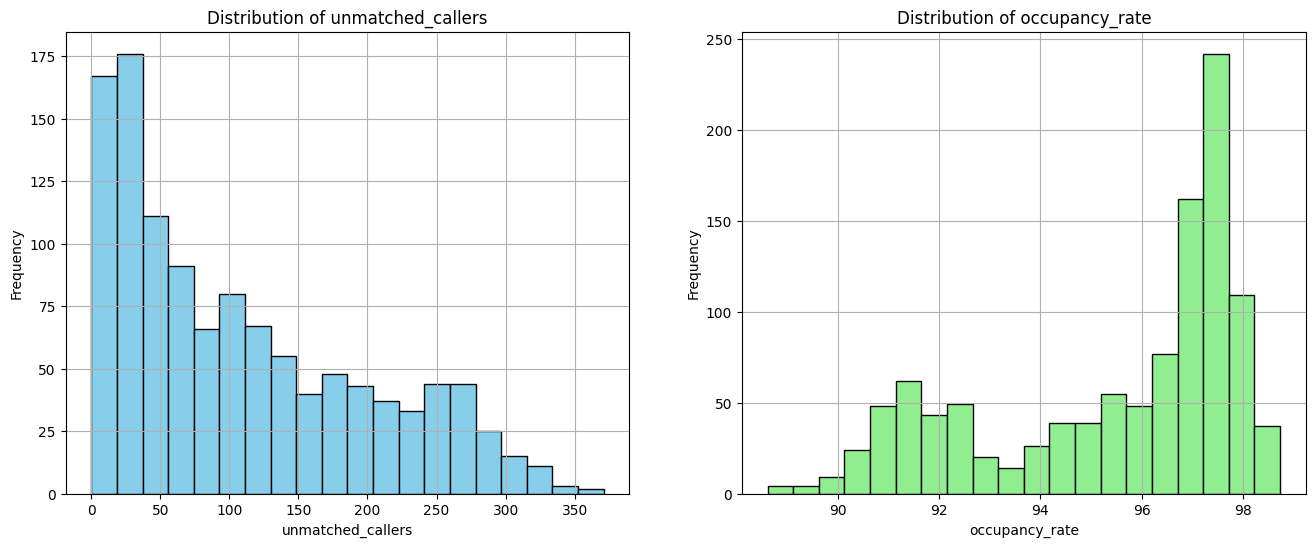

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot for 'unmatched_callers'
axs[0].hist(calls['unmatched_callers'], bins=20, color='skyblue', edgecolor='black')
axs[0].set_title('Distribution of unmatched_callers')
axs[0].set_xlabel('unmatched_callers')
axs[0].set_ylabel('Frequency')
axs[0].grid(True)

# Plot for 'occupancy_rate'
axs[1].hist(daily_occupancy_rate['occupancy_rate'], bins=20, color='lightgreen', edgecolor='black')
axs[1].set_title('Distribution of occupancy_rate')
axs[1].set_xlabel('occupancy_rate')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

plt.show()

* Check whether there is any relationship between day of the week and number of unmatched callers:

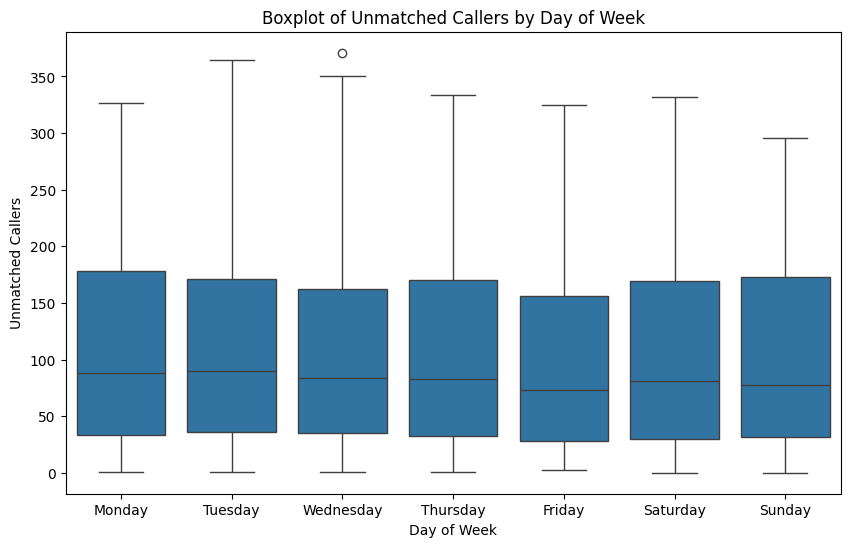

In [14]:
weather_calls_occupancy_flow_daily = pd.merge(calls, weather, left_index=True, right_index=True, how='left')

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='unmatched_callers', data=weather_calls_occupancy_flow_daily, order=sorted(weather_calls_occupancy_flow_daily['day_of_week'].unique()))
plt.title('Boxplot of Unmatched Callers by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Unmatched Callers')

plt.xticks(range(len(day_order)), day_order)

plt.show()

We need to focus on Motel/Hotel type of shelters since they have adjustable capacity. Let's calculate averate daily capacity for these.

In [15]:
concatenated_occupancy_flexible = concatenated_occupancy[concatenated_occupancy['OVERNIGHT_SERVICE_TYPE'] == 'Motel/Hotel Shelter'].copy()

grouped_unflexible = concatenated_occupancy_flexible.groupby('Date').agg({'capacity': 'sum', 'occupancy_rate': 'mean'})

average_daily_capacity = grouped_unflexible.resample('MS').mean().rename(columns={'capacity': 'average_daily_adjustable_capacity', 'occupancy_rate': 'average_daily_occupancy_rate_adjustable'}).round(2)

capacity_adjustable_shelter = average_daily_capacity['average_daily_adjustable_capacity'].mean()

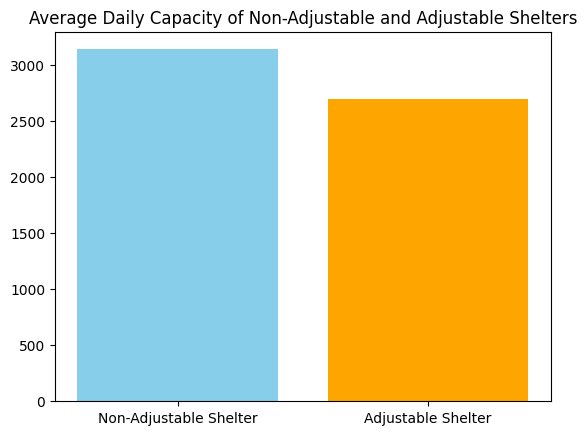

In [16]:
bar_positions = [0, 1]
bar_heights = [capacity_non_adjustable_shelter, capacity_adjustable_shelter]
bar_colors = ['skyblue', 'orange']

plt.bar(bar_positions, bar_heights, color=bar_colors)
plt.xticks(bar_positions, ['Non-Adjustable Shelter', 'Adjustable Shelter'])

plt.title('Average Daily Capacity of Non-Adjustable and Adjustable Shelters')
plt.show()

Let us see if there is any seasonal component in the historical data: 

In [17]:
average_daily_capacity = grouped_unflexible.resample('MS').mean().rename(columns={'capacity': 'average_daily_adjustable_capacity', 'occupancy_rate': 'average_daily_occupancy_rate_adjustable'}).round(2)
merged_calls_occupancy_flow_monthly = pd.merge(average_daily_capacity, merged_calls_flow_monthly, left_index=True, right_on='Date', how='inner')
date_column = merged_calls_occupancy_flow_monthly['Date']
merged_calls_occupancy_flow_monthly.drop(columns=['Date'], inplace=True)
merged_calls_occupancy_flow_monthly.insert(0, 'Date', date_column)
merged_calls_occupancy_flow_monthly.set_index('Date', inplace=True)
merged_calls_occupancy_flow_monthly = pd.merge(average_other_daily_capacity, merged_calls_occupancy_flow_monthly, how='inner', left_index=True, right_index=True)

merged_calls_occupancy_flow_monthly[['average_daily_total_calls', 'average_daily_unmatched_callers']] = merged_calls_occupancy_flow_monthly[['average_daily_total_calls', 'average_daily_unmatched_callers']].round(2)
merged_calls_occupancy_flow_monthly.tail()

,average_daily_nonadjustable_capacity,average_daily_occupancy_rate_nonadjustable,average_daily_adjustable_capacity,average_daily_occupancy_rate_adjustable,average_daily_total_calls,average_daily_unmatched_callers,newly_identified,actively_homeless,became_inactive,returned_to_shelter
Date,,,,,,,,,,
2023-08-01,3829.71,98.26,2483.87,99.39,888.32,244.26,539,9988,632,201
2023-09-01,3979.63,97.61,2471.83,99.66,979.87,277.97,841,10212,483,194
2023-10-01,4077.35,97.40,2496.16,99.52,1094.16,291.29,929,10111,502,165
2023-11-01,4132.60,97.54,2481.33,99.51,969.90,245.30,1113,10498,472,267
2023-12-01,4196.26,97.08,2475.77,99.55,805.94,164.74,886,10607,447,266


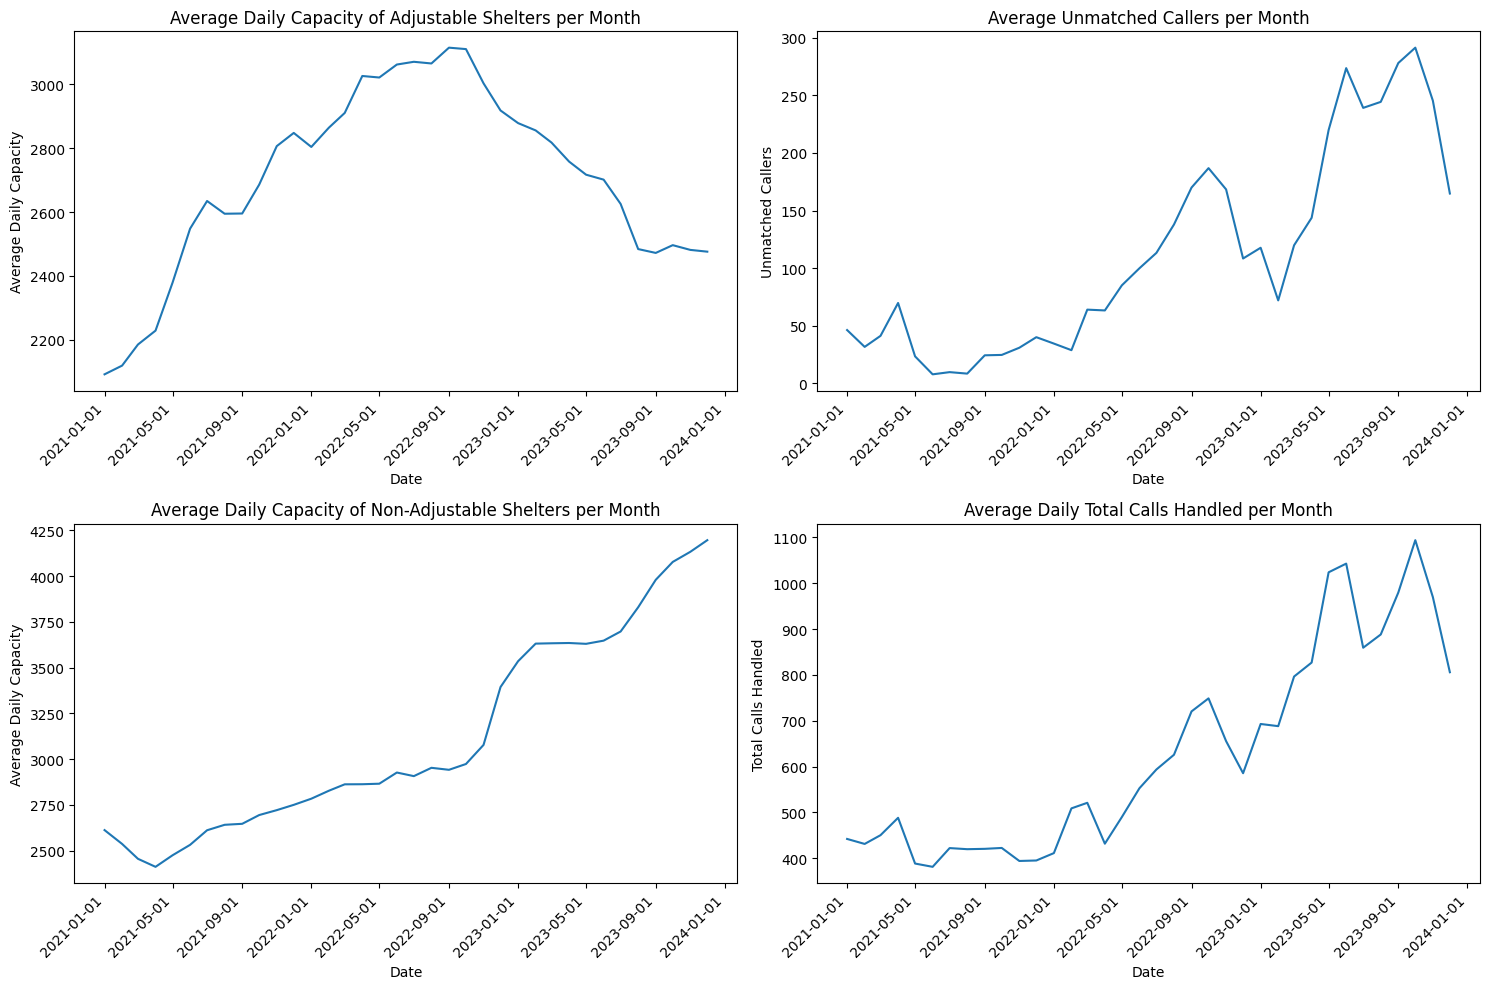

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

plt.subplot(2, 2, 1)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot1 = sns.lineplot(data=merged_calls_occupancy_flow_monthly, x='Date', y='average_daily_adjustable_capacity')
    plot1.set_xticks(plot1.get_xticks())  # Set the x-axis tick positions
    plot1.set_xticklabels(plot1.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.xlabel('Date')
plt.ylabel('Average Daily Capacity')
plt.title('Average Daily Capacity of Adjustable Shelters per Month')

plt.subplot(2, 2, 2)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot2 = sns.lineplot(data=merged_calls_occupancy_flow_monthly, x='Date', y='average_daily_unmatched_callers')
    plot2.set_xticks(plot2.get_xticks())  # Set the x-axis tick positions
    plot2.set_xticklabels(plot2.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.xlabel('Date')
plt.ylabel('Unmatched Callers')
plt.title('Average Unmatched Callers per Month')

plt.subplot(2, 2, 3)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot3 = sns.lineplot(data=merged_calls_occupancy_flow_monthly, x='Date', y='average_daily_nonadjustable_capacity')
    plot3.set_xticks(plot3.get_xticks())  # Set the x-axis tick positions
    plot3.set_xticklabels(plot3.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.xlabel('Date')
plt.ylabel('Average Daily Capacity')
plt.title('Average Daily Capacity of Non-Adjustable Shelters per Month')

plt.subplot(2, 2, 4)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot4 = sns.lineplot(data=merged_calls_occupancy_flow_monthly, x='Date', y='average_daily_total_calls')
    plot4.set_xticks(plot4.get_xticks())  # Set the x-axis tick positions
    plot4.set_xticklabels(plot4.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.xlabel('Date')
plt.ylabel('Total Calls Handled')
plt.title('Average Daily Total Calls Handled per Month')

plt.tight_layout()
plt.show()

Let us conduct the t-tests to see whether there is a significant seasonal effect on the selected variables:

newly_identified: 
t-statistic: 0.16602987177514428
p-value: 0.8693265141990705 

returned_to_shelter: 
t-statistic: 9.903443022198156
p-value: 1.1918615747542516e-10 

became_inactive: 
t-statistic: -5.459332384784218
p-value: 7.913462469177361e-06 

average_daily_total_calls: 
t-statistic: -6.88893413600925
p-value: 1.7353481576535172e-07 

average_daily_unmatched_callers: 
t-statistic: -4.61201517413596
p-value: 8.006545614428855e-05 

average_daily_occupancy_rate_adjustable: 
t-statistic: -0.44383746320281786
p-value: 0.6605712129084421 



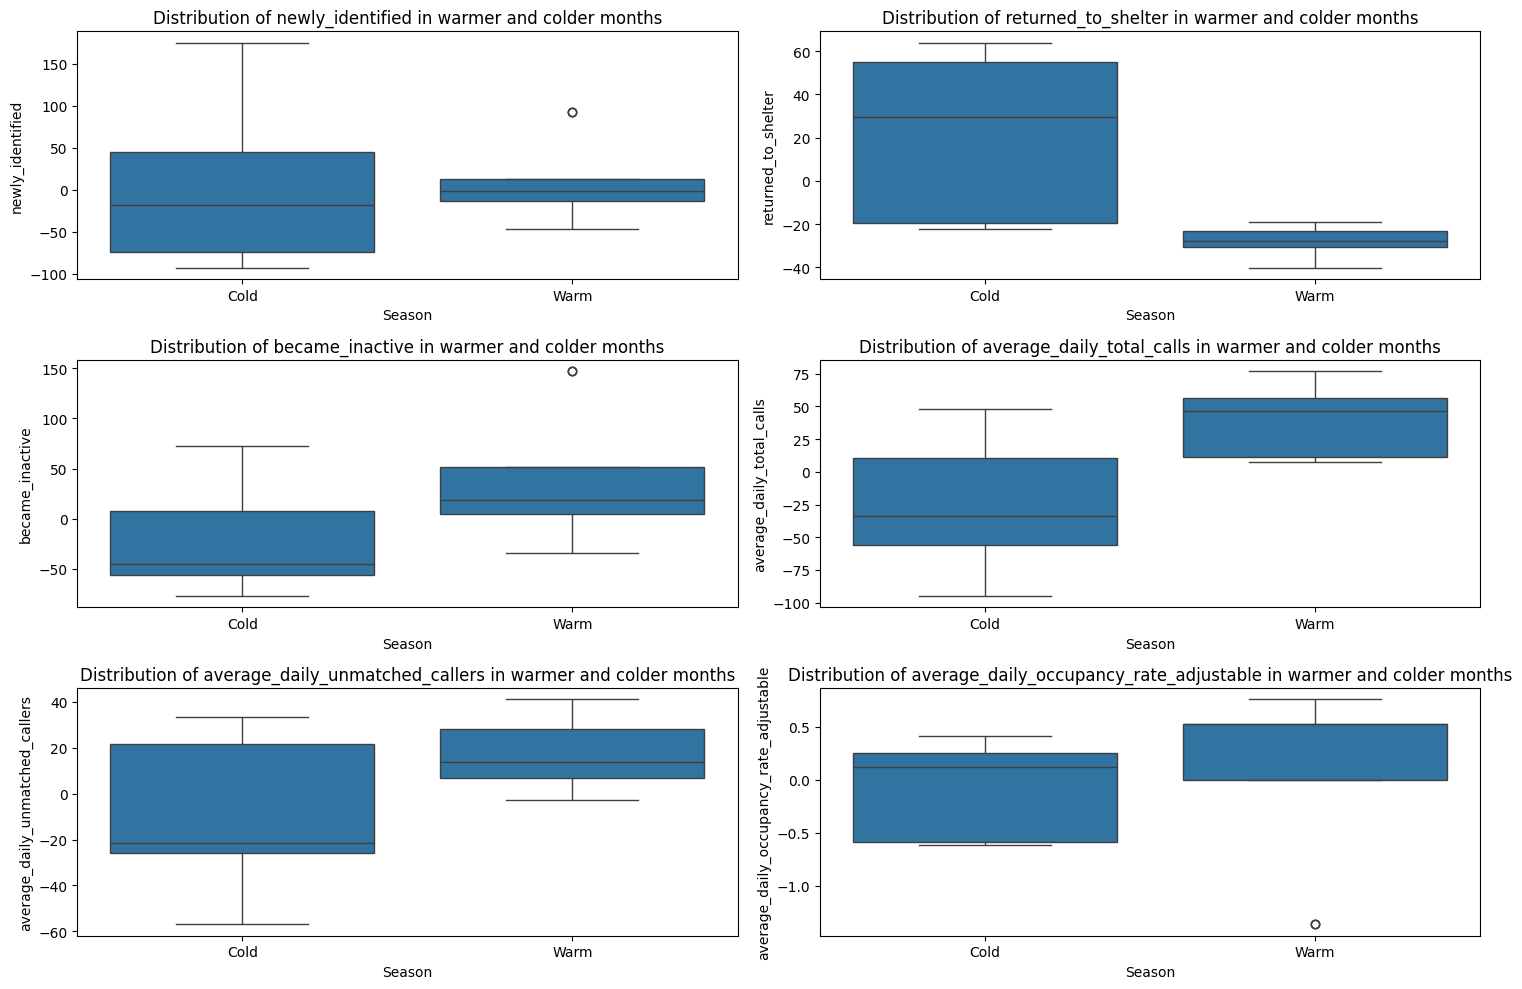

In [19]:
variables = ['newly_identified', 'returned_to_shelter',  'became_inactive',  'average_daily_total_calls', 'average_daily_unmatched_callers', 'average_daily_occupancy_rate_adjustable']

fig, axes = plt.subplots(3, 2, figsize=(15, 10))

axes = axes.flatten()

for i, variable in enumerate(variables):

    result = seasonal_decompose(merged_calls_occupancy_flow_monthly[variable])
    seasonal_data = pd.DataFrame({variable: result.seasonal})
    seasonal_data['Month'] = seasonal_data.index.month

    cold_months = [11, 12, 1, 2,3]
    warm_months = [5, 6, 7, 8,9]

    winter_values = seasonal_data[seasonal_data['Month'].isin(cold_months)][variable]
    summer_values = seasonal_data[seasonal_data['Month'].isin(warm_months)][variable]

    t_statistic, p_value = ttest_ind(winter_values, summer_values)

    seasonal_data['Season'] = np.where(seasonal_data['Month'].isin(warm_months), 'Warm', 'Cold')
    seasonal_data['Season'] = np.where(seasonal_data['Month'].isin(cold_months), 'Cold', seasonal_data['Season'])

    sns.boxplot(x='Season', y=variable, data=seasonal_data, order=['Cold', 'Warm'], ax=axes[i])
    axes[i].set_title(f'Distribution of {variable} in warmer and colder months')

    print(f"{variable}: \nt-statistic: {t_statistic}")
    print("p-value:", p_value, "\n")

plt.tight_layout()
plt.show()

# Observations and Ideas from EDA

* The inflow of first-time shelter seekers remains constant throughout the year. However, a seasonal pattern in the outflow and inflow of individuals who have previously utilized the shelter system is evident: more people leave shelters during the warmer months and return during the colder months.

* Contrary to expectations, the demand for shelters increases during the warmer months. The number of shelter requests and the instances of individuals not being matched with a shelter bed decrease during the winter months. The occupancy rate is also lower during the colder months.

* Weekly fluctuations do not have a significant effect on the number of unmathced callers.

* The demand for shelter space significantly exceeds the available supply, with the median occupancy rate reaching 97%. This surplus in demand is evident from the increasing number of individuals unable to secure overnight accommodation due to limited capacity. 

* This implies that accurately gauging and forecasting daily demand for overnight shelter space necessitates a focus on predicting the number of unmatched callers. 

# Building a Model

* Feature engineering:

In [20]:
merged_calls_daily = pd.merge(calls, calls_full, on = 'Date', how='inner')
merged_calls_daily = merged_calls_daily[['unmatched_callers', 'total_calls_handled']]

daily_average_occupancy_rate = concatenated_occupancy.groupby(concatenated_occupancy.index.date)['occupancy_rate'].mean().round(2)

merged_calls_occupancy_daily = pd.merge(daily_average_occupancy_rate, merged_calls_daily, left_index=True, right_index=True, how='inner')

merged_calls_occupancy_daily['cold_season'] = merged_calls_occupancy_daily.index.month.isin([11, 12, 1, 2, 3]).astype(int)

shelter_flow = shelter_flow[['returned_from_housing','returned_to_shelter', 'newly_identified', 'became_inactive']]

shelter_flow_daily = shelter_flow.resample('D').ffill()

shelter_flow_daily.index = pd.to_datetime(shelter_flow_daily.index)

merged_calls_occupancy_flow_daily = pd.merge(merged_calls_occupancy_daily, shelter_flow_daily, left_index=True, right_index=True, how='left')

merged_calls_occupancy_flow_daily.reset_index(inplace=True)
merged_calls_occupancy_flow_daily.ffill(inplace=True)
first_columns_to_int = ['returned_from_housing','returned_to_shelter', 'newly_identified', 'became_inactive']
merged_calls_occupancy_flow_daily[first_columns_to_int] = merged_calls_occupancy_flow_daily[first_columns_to_int].astype(int)

merged_calls_occupancy_flow_daily = merged_calls_occupancy_flow_daily.rename(columns={'index': 'Date'})
merged_calls_occupancy_flow_daily = merged_calls_occupancy_flow_daily.set_index('Date')

* Assume that temperature can be forecasted a day prior, and occupancy_rate cannot. That means, we need to add a day-lag to occupancy_rate.

* Occupancy rate has a highly left-skewing density distribution, which impedes the model optimization. We will apply log-transformation.

* Create lagged versions of unmatched_callers (lagged by day, two days, week) variables for the later used non-SARIMAX models.

In [21]:
weather_calls_occupancy_flow_daily = pd.merge(merged_calls_occupancy_flow_daily, weather, left_index=True, right_index=True, how='left')

weather_calls_occupancy_flow_daily.index.freq = 'D'

weather_calls_occupancy_flow_daily['unmatched_callers_lag_day'] = weather_calls_occupancy_flow_daily['unmatched_callers'].shift(1)
weather_calls_occupancy_flow_daily['unmatched_callers_lag_day'] = weather_calls_occupancy_flow_daily['unmatched_callers_lag_day'].ffill()

weather_calls_occupancy_flow_daily['unmatched_callers_lag_twodays'] = weather_calls_occupancy_flow_daily['unmatched_callers_lag_day'].shift(1)
weather_calls_occupancy_flow_daily['unmatched_callers_lag_twodays'] = weather_calls_occupancy_flow_daily['unmatched_callers_lag_twodays'].ffill()

weather_calls_occupancy_flow_daily['unmatched_callers_lag_week'] = weather_calls_occupancy_flow_daily['unmatched_callers'].shift(7)
weather_calls_occupancy_flow_daily['unmatched_callers_lag_week'] = weather_calls_occupancy_flow_daily['unmatched_callers_lag_week'].ffill()

weather_calls_occupancy_flow_daily['occupancy_rate_lag_day'] = weather_calls_occupancy_flow_daily['occupancy_rate'].shift(1)
weather_calls_occupancy_flow_daily['occupancy_rate_lag_day'] = weather_calls_occupancy_flow_daily['occupancy_rate_lag_day'].ffill()
weather_calls_occupancy_flow_daily['occupancy_rate_lag_day'] = weather_calls_occupancy_flow_daily['occupancy_rate_lag_day'].bfill()
weather_calls_occupancy_flow_daily['occupancy_rate_lag_day'] = np.log(weather_calls_occupancy_flow_daily['occupancy_rate_lag_day'])

weather_calls_occupancy_flow_daily['total_calls_handled_lag_day'] = weather_calls_occupancy_flow_daily['total_calls_handled'].shift(1)
weather_calls_occupancy_flow_daily['total_calls_handled_lag_day'] = weather_calls_occupancy_flow_daily['total_calls_handled_lag_day'].ffill()
weather_calls_occupancy_flow_daily['total_calls_handled_lag_day'] = weather_calls_occupancy_flow_daily['total_calls_handled_lag_day'].bfill()

weather_calls_occupancy_flow_daily = weather_calls_occupancy_flow_daily.drop(['total_calls_handled', 'occupancy_rate', 'day_of_week', 'day_1', 
'day_2', 'day_3', 'day_4', 'day_5', 'day_6'], axis=1)

weather_calls_occupancy_flow_daily.dropna(inplace=True)

In [22]:
weather_calls_occupancy_flow_daily.head()

,unmatched_callers,cold_season,returned_from_housing,returned_to_shelter,newly_identified,became_inactive,min_temp_cels,total_precip_mm,unmatched_callers_lag_day,unmatched_callers_lag_twodays,unmatched_callers_lag_week,occupancy_rate_lag_day,total_calls_handled_lag_day
Date,,,,,,,,,,,,,
2021-01-08,64,1,84,425,647,660,-9.3,0.0,30.0,39.0,19.0,4.525261,440.0
2021-01-09,70,1,84,425,647,660,-4.3,0.0,64.0,30.0,22.0,4.533782,475.0
2021-01-10,74,1,84,425,647,660,-5.6,0.0,70.0,64.0,28.0,4.535391,506.0
2021-01-11,75,1,84,425,647,660,-6.1,0.0,74.0,70.0,28.0,4.531201,477.0
2021-01-12,80,1,84,425,647,660,-2.1,0.0,75.0,74.0,45.0,4.532492,529.0


# ARIMA model

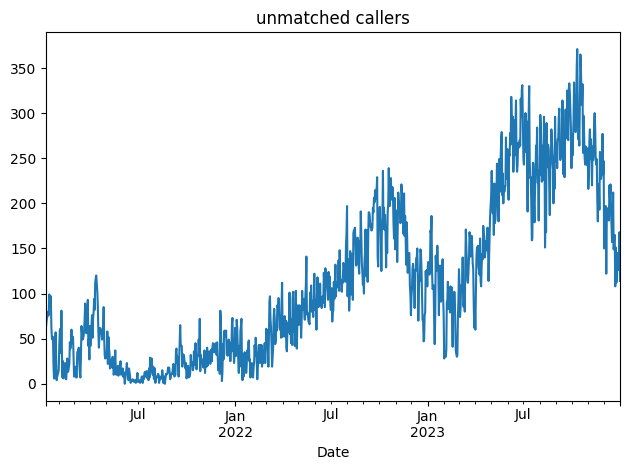

In [63]:
weather_calls_occupancy_flow_daily.unmatched_callers.plot(title='unmatched callers')
plt.tight_layout(); plt.show()

* Checker whether time-series is stationary:

In [64]:
result = adfuller(weather_calls_occupancy_flow_daily.unmatched_callers)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.3239159662613897
p-value: 0.6181609534563539


* High p-value – the time-series is non-stationary. Need to difference the data to get rid of the linear trend.

ADF Statistic: -8.407638526983591
p-value: 8.182872668096781e-12


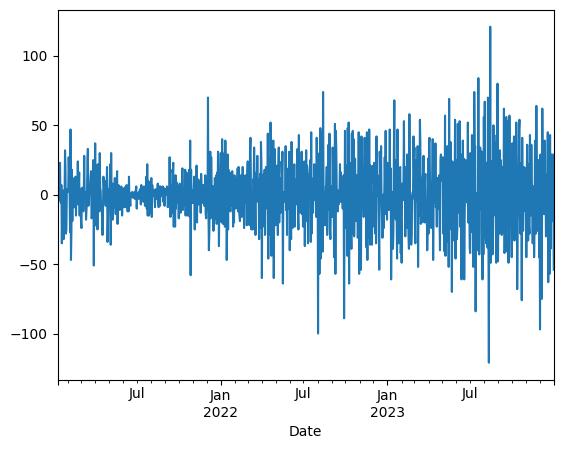

In [51]:
diff_unmatched_callers = weather_calls_occupancy_flow_daily['unmatched_callers'].diff().dropna()

result = adfuller(diff_unmatched_callers, regression='ct')
print("ADF Statistic:", result[0])
print("p-value:", result[1])

diff_unmatched_callers.plot()
plt.show()

* Explore any presence of autocorrelation:

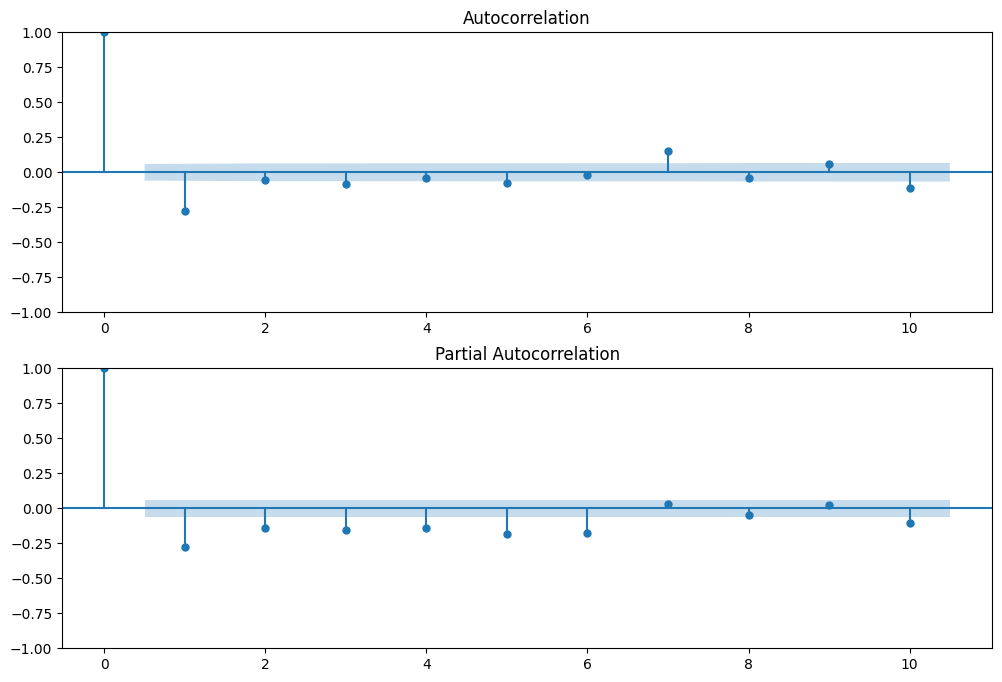

In [52]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
plot_acf(diff_unmatched_callers, lags=10, ax=ax1)
plot_pacf(diff_unmatched_callers, lags=10,  ax=ax2)

plt.show()

* Some autocorrelation is still present. We will use an algorithm that selects the set of AR & MA parameters that yields the best BIC score.

In [53]:
order_aic_bic = []

for p in range(5):
    for q in range(5):
        try:
            try_model = ARIMA(weather_calls_occupancy_flow_daily.unmatched_callers, order=(p, 1, q), freq='D')
            try_results = try_model.fit()

            order_aic_bic.append((p, q, try_results.aic, try_results.bic))

        except Exception as e:
            print(f"Error for p={p}, q={q}: {e}")
            order_aic_bic.append((p, q, None, None))

order_aic_bic = pd.DataFrame(order_aic_bic, columns=['AR', 'MA', 'AIC', 'BIC'])
top_models = order_aic_bic.dropna().sort_values(by='BIC').head(5)
print(top_models)


    AR  MA          AIC          BIC
18   3   3  9858.979855  9893.918093
24   4   4  9854.401567  9899.322159
13   2   3  9881.649992  9911.597053
6    1   1  9896.779772  9911.753302
3    0   3  9897.002634  9916.967342


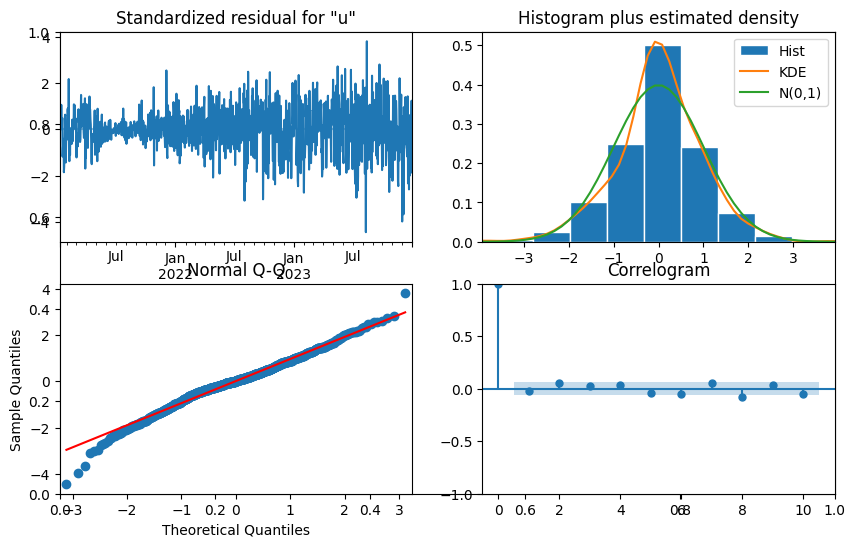

                               SARIMAX Results                                
Dep. Variable:      unmatched_callers   No. Observations:                 1088
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -4922.490
Date:                Thu, 14 Mar 2024   AIC                           9858.980
Time:                        23:53:10   BIC                           9893.918
Sample:                    01-08-2021   HQIC                          9872.205
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5532      0.048     32.131      0.000       1.458       1.648
ar.L2         -1.4017      0.060    -23.462      0.000      -1.519      -1.285
ar.L3          0.3457      0.046      7.481      0.0

In [54]:
model_arima = ARIMA(weather_calls_occupancy_flow_daily.unmatched_callers, order=(3,1,3))
results_arima = model_arima.fit()

predictions_arima = results_arima.predict()

fig, ax = plt.subplots(figsize=(10, 6))
results_arima.plot_diagnostics(fig=fig)
plt.show()

print(results_arima.summary())

* The residuals is not normally distributed – some information is still missing from the data. Need to try a more complex model.

# Rolling ARIMA's predictions

In [23]:
cutoff_date = pd.to_datetime('2023-01-01')
train_data = weather_calls_occupancy_flow_daily[:cutoff_date]
test_data = weather_calls_occupancy_flow_daily[cutoff_date:]

* Apply this model to the test data (for the year 2023) to simulate a real-world scenario. We'll use a rolling window of one day, meaning we'll predict the next day's number of unmatched callers each day. The Mean Absolute Error (MAE) will then be calculated as the average discrepancy between our daily predictions and the actual observed values.

In [56]:
history_arima = train_data['unmatched_callers'].tolist()

predictions_arima_rolling = []

for t in range(len(test_data)):
    model_arima_rolling = ARIMA(history_arima, order=(3,1,3))
    model_fit = model_arima_rolling.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions_arima_rolling.append(yhat)
    
    obs = test_data.iloc[t]['unmatched_callers']
    history_arima.append(obs)

mae_arima_rolling = mean_absolute_error(test_data['unmatched_callers'], predictions_arima_rolling)
print(f"ARIMA's MAE on the test data: {mae_arima_rolling:.3f}")

ARIMA's MAE on the test data: 23.041


# SARIMAX model tuning

* We will now introduce the seasonal component to the data. First, let us look at the weekly autocorrelation chart:

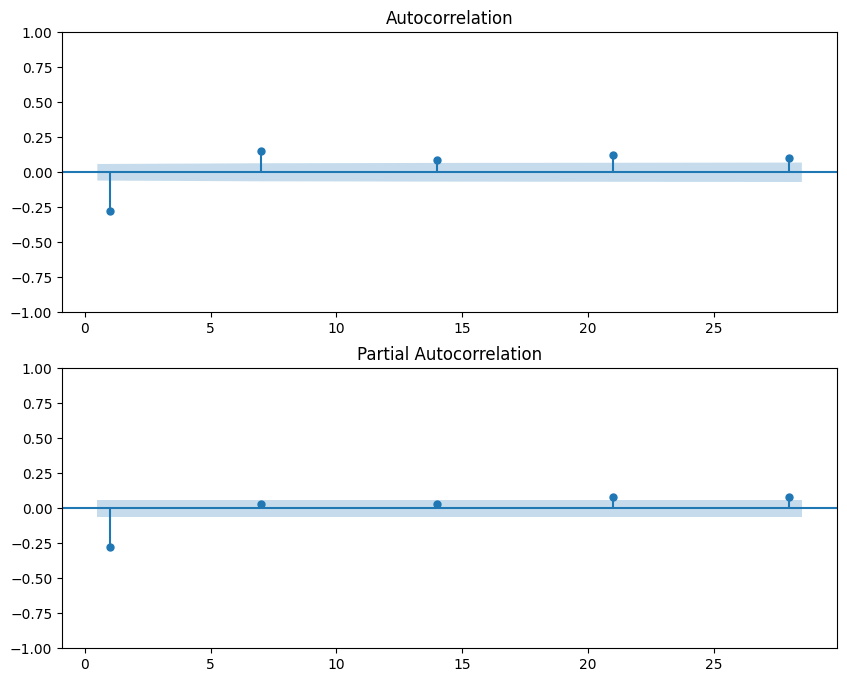

In [622]:
lags = [1,7,14,21,28]

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,8))

plot_acf(diff_unmatched_callers, lags = lags, ax = ax1)
plot_pacf(diff_unmatched_callers, lags = lags, ax = ax2)

plt.show()


* Weekly AR is present. Let us find the best set of AR & MA parameters for the seasonal component of SARIMA model:


In [623]:
model_auto = pm.auto_arima(weather_calls_occupancy_flow_daily.unmatched_callers,
                        seasonal=True, m=7,
                        d=1, D=1,
                        max_p=2, max_q=2,
                        error_action='ignore',
                        suppress_warnings=True)

print(model_auto.coefs())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                 1095
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2], 7)   Log Likelihood               -4937.506
Date:                                Mon, 11 Mar 2024   AIC                           9889.013
Time:                                        00:55:42   BIC                           9923.951
Sample:                                    01-01-2021   HQIC                          9902.238
                                         - 12-31-2023                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4559      0.037     12.385      0.000       0.384       0.528
ar.

* Model without seasonal differencing yields better BIC and MAE. Hence, we choose SARIMAX(2, 1, 1)x(1, 0, 2, 7) as our model:

In [66]:
model_sarima = SARIMAX(weather_calls_occupancy_flow_daily.unmatched_callers,  
                       order=(2, 1, 1), 
                       seasonal_order=(1, 0, 1, 7))

results_sarima = model_sarima.fit(disp=0)
predictions_sarima = results_sarima.predict()

mae_sarima = mean_absolute_error(weather_calls_occupancy_flow_daily.unmatched_callers, predictions_sarima)

print("SARIMA's MAE: {}".format(mae_sarima.round(2)))
print('MAE improved: {}%'.format((100*((mae_arima - mae_sarima)/mae_arima)).round(2)))
print('BIC improved: {}%'.format((100*((results_arima.bic - results_sarima.bic)/results_arima.bic)).round(2)))

SARIMA's MAE: 16.7
MAE improved: 0.0%
BIC improved: 0.18%


# Rolling SARIMA's predictions

In [626]:
history_sarima = train_data['unmatched_callers'].tolist()
predictions_sarima_rolling = list()

for t in range(len(test_data)):
    model_sarima_rolling = SARIMAX(history_sarima, order=(2,1,1), seasonal_order=(1,0,1,7))
    model_fit = model_sarima_rolling.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions_sarima_rolling.append(yhat)
    obs = test_data.iloc[t]['unmatched_callers']
    history_sarima.append(obs)

mae_sarima_rolling = mean_absolute_error(test_data.unmatched_callers, predictions_sarima_rolling)
print("SARIMA's MAE on the test data: %.3f" % mae_sarima_rolling)


SARIMA's MAE on the test data: 22.684


# SARIMAX feature selection

* We now want to introduce exogenous vairables to our model; let us first choose the features that lower the BIC score of the model:

In [29]:
endog = weather_calls_occupancy_flow_daily.unmatched_callers

columns_to_exclude = ['unmatched_callers', 'occupancy_rate', 'total_calls_handled', 'unmatched_callers_lag_day', 'unmatched_callers_lag_week', 'unmatched_callers_lag_twodays']
columns_to_include = [col for col in weather_calls_occupancy_flow_daily.columns if col not in columns_to_exclude]

exog_features = weather_calls_occupancy_flow_daily[columns_to_include].copy()
feature_names = exog_features.columns

best_feature = None

best_bic = float('inf')
current_features = []

while True:
    improvement = False
    for feature in exog_features.columns.difference(current_features):
        try:
            model = SARIMAX(endog, exog=exog_features[current_features + [feature]], 
                            order=(2,1,1), seasonal_order=(1,0,1,7), enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(disp=0)

            if results.bic < best_bic:
                best_bic = results.bic
                best_feature = feature
                improvement = True
        except:
            continue

    if improvement:
        current_features.append(best_feature)
        print(f"Added {best_feature}, BIC: {best_bic}")
    else:
        break

print(f"Final features: {current_features}")

Added min_temp_cels, BIC: 9795.19679902407
Final features: ['min_temp_cels']


* occupancy rate has also shown to imporve BIC and MAE score. We will add it to the selected exogenous features

In [30]:
current_features.append('occupancy_rate_lag_day')
print(current_features)

['min_temp_cels', 'occupancy_rate_lag_day']


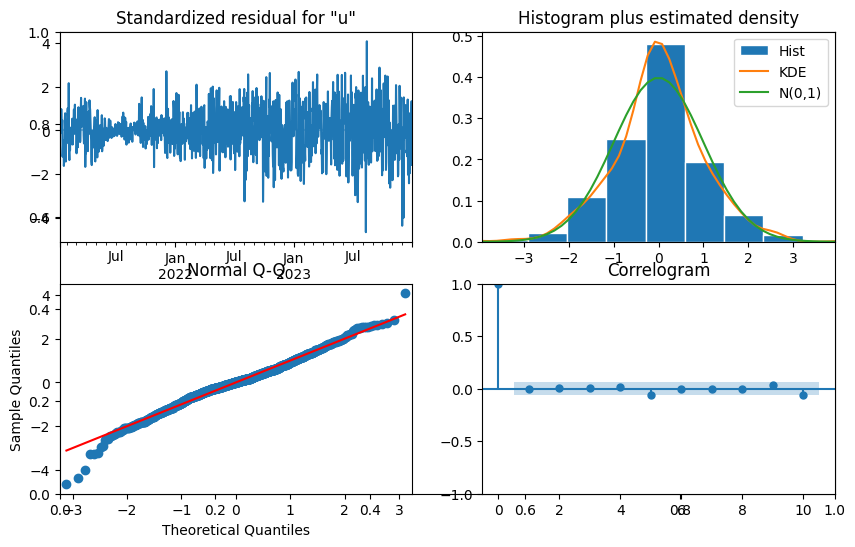

                                     SARIMAX Results                                     
Dep. Variable:                 unmatched_callers   No. Observations:                 1088
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -4907.271
Date:                           Fri, 15 Mar 2024   AIC                           9830.542
Time:                                   00:02:18   BIC                           9870.472
Sample:                               01-08-2021   HQIC                          9845.657
                                    - 12-31-2023                                         
Covariance Type:                             opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
min_temp_cels              0.8793      0.206      4.269      0.000       0.476       1.283
occupan

In [70]:
model_sarimax = SARIMAX(weather_calls_occupancy_flow_daily.unmatched_callers,  
                       exog = weather_calls_occupancy_flow_daily[current_features],
                       order=(2, 1, 1), 
                       seasonal_order=(1, 0, 1, 7))

results_sarimax = model_sarimax.fit(disp=0)
predictions_sarimax = results_sarimax.predict()

fig, ax = plt.subplots(figsize=(10, 6))
results_sarimax.plot_diagnostics(fig=fig)
plt.show()

print(results_sarimax.summary())



In [78]:
print(predictions_sarimax)

Date
2021-01-08    343.607210
2021-01-09     69.111763
2021-01-10     68.728887
2021-01-11     71.311111
2021-01-12     76.636136
                 ...    
2023-12-27    151.830753
2023-12-28    141.898742
2023-12-29    126.357843
2023-12-30    138.398092
2023-12-31    148.794683
Freq: D, Name: predicted_mean, Length: 1088, dtype: float64


* The residuals are not normally distributed. The model needs potential refinement.

# Rolling SARIMA's predictions

In [92]:
train_endog = train_data['unmatched_callers']
test_sarimax = test_data['unmatched_callers']
train_exog = train_data[current_features]
test_exog = test_data[current_features]


history_exog = train_exog.values.tolist()  
print(train_exog.values))

<class 'numpy.ndarray'>


In [98]:
train_endog = train_data['unmatched_callers']
test_sarimax = test_data['unmatched_callers']
train_exog = train_data[current_features]
test_exog = test_data[current_features]

history_endog = [x for x in train_endog]
history_exog = train_exog.values.tolist()  
predictions_sarimax = []

for t in range(len(test_sarimax)):
    model = SARIMAX(history_endog, exog=history_exog,
                    order=(2, 1, 1),  
                    seasonal_order=(1, 0, 1, 7))
    model_fit = model.fit(disp = 0)
    
    next_exog = test_exog.iloc[t:t+1].values  
    
    output = model_fit.forecast(exog=next_exog)
    yhat = output[0]
    predictions_sarimax.append(yhat)
    
    obs = test_sarimax.iloc[t]
    history_endog.append(obs)

    history_exog.append(next_exog[0].tolist())  

mae_sarimax = mean_absolute_error(test_sarimax, predictions_sarimax)
print("Mean Absolute Error (MAE) on test data:", mae_sarimax)

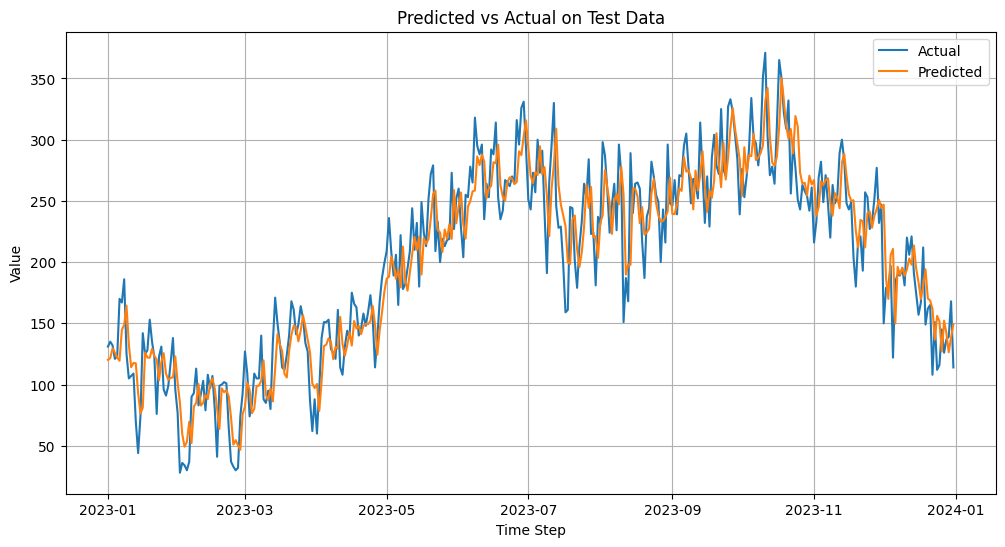

In [647]:
plt.figure(figsize=(12, 6))
plt.plot(test_sarimax.index, test_sarimax, label='Actual')
plt.plot(test_sarimax.index, predictions_sarimax, label='Predicted')
plt.title('Predicted vs Actual on Test Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# OTHER MODELS

# Linear Regression

In [649]:
initial_features = ['occupancy_rate_lag_day',
       'cold_season', 'returned_from_housing', 'returned_to_shelter',
       'newly_identified', 'became_inactive', 'min_temp_cels',
       'total_precip_mm',
       'total_calls_handled_lag_day', 'total_calls_handled_lag_day',
       'unmatched_callers_lag_week', 'unmatched_callers_lag_day', 'unmatched_callers_lag_twodays']

history_y = train_data['unmatched_callers'].values
selected_features = []

best_mae = np.inf
improvement = True

while improvement:
    improvement = False
    for feature in initial_features:
        if feature not in selected_features:
            # Try adding this feature
            temp_features = selected_features + [feature]
            
            # Reinitialize history_X with the current set of features
            history_X = train_data[temp_features]
            
            predictions_temp = []
            for t in range(len(test_data)):
                # Note: In a real rolling forecast, you'd retrain here with the growing history_X
                # For simplicity, we're training once per iteration before the loop for demonstration
                model_temp = LinearRegression().fit(history_X, history_y)
                
                next_row = test_data.iloc[[t]]
                next_X = next_row[temp_features]
                yhat = model_temp.predict(next_X)[0]
                predictions_temp.append(yhat)
            
            temp_mae = mean_absolute_error(test_data['unmatched_callers'], predictions_temp)
            
            # Check if the temporary feature set gives better performance
            if temp_mae < best_mae:
                best_mae = temp_mae
                best_feature = feature
                improvement = True
    
    # If an improvement was found, update the selected features and the best MAE
    if improvement:
        selected_features.append(best_feature)
        print(f"Added {best_feature}, New best MAE: {best_mae}")

# Final selected features and performance
print(f"Selected features: {selected_features}")
print(f"Best MAE with selected features: {best_mae}")


Added unmatched_callers_lag_day, New best MAE: 25.801356184367464
Added unmatched_callers_lag_week, New best MAE: 23.878839504254184
Added unmatched_callers_lag_twodays, New best MAE: 23.52256618446129
Added returned_to_shelter, New best MAE: 23.37662083809538
Added newly_identified, New best MAE: 23.268505544945405
Added min_temp_cels, New best MAE: 23.21216988668201
Added returned_from_housing, New best MAE: 23.178817629753006
Selected features: ['unmatched_callers_lag_day', 'unmatched_callers_lag_week', 'unmatched_callers_lag_twodays', 'returned_to_shelter', 'newly_identified', 'min_temp_cels', 'returned_from_housing']
Best MAE with selected features: 23.178817629753006


In [652]:
history_X = train_data[['unmatched_callers_lag_day', 'unmatched_callers_lag_week', 'occupancy_rate_lag_day', 'unmatched_callers_lag_twodays', 'returned_to_shelter', 'newly_identified', 'min_temp_cels', 'returned_from_housing']]
history_y = train_data['unmatched_callers'].values 

predictions_linear = []

for t in range(len(test_data)):
    model_linear = LinearRegression()
    model_linear.fit(history_X, history_y)  
    
    next_row = test_data.iloc[t:t+1]  
    next_X = next_row[['unmatched_callers_lag_day', 'unmatched_callers_lag_week', 'occupancy_rate_lag_day', 'unmatched_callers_lag_twodays', 'returned_to_shelter', 'newly_identified', 'min_temp_cels', 'returned_from_housing']]
    
    yhat = model_linear.predict(next_X)[0]  
    predictions_linear.append(yhat)  
    
    true_value = next_row['unmatched_callers'].values[0]
    history_y = np.append(history_y, true_value)  
    history_X = pd.concat([history_X, next_X], ignore_index=True)

mae_linear_rolling = mean_absolute_error(test_data.unmatched_callers, predictions_linear)
print("Mean Absolute Error (MAE) on test data with rolling forecast:", mae_linear_rolling)


Mean Absolute Error (MAE) on test data with rolling forecast: 23.118330770702336


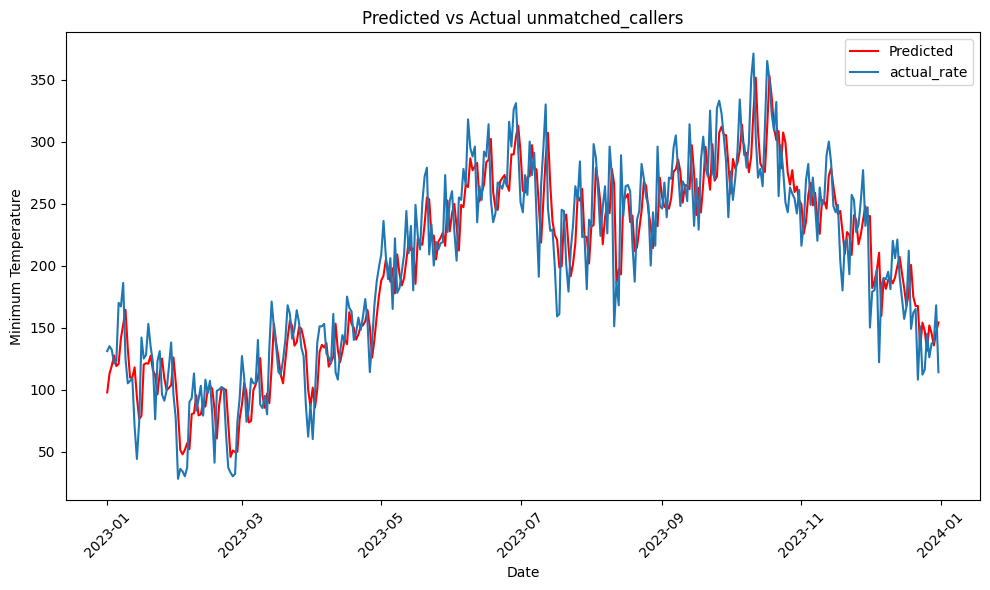

In [653]:
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, predictions_linear, label='Predicted', c= 'r')
plt.plot(test_data.index, test_data.unmatched_callers, label='actual_rate')
plt.xlabel('Date')
plt.ylabel('Minimum Temperature')
plt.title('Predicted vs Actual unmatched_callers')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature Importance with LGBM


In [28]:
history_X = train_data[['occupancy_rate_lag_day', 'cold_season', 'returned_from_housing', 'returned_to_shelter',
                    'newly_identified', 'became_inactive', 'min_temp_cels', 'total_precip_mm', 'unmatched_callers_lag_twodays',
                    'total_calls_handled_lag_day', 'unmatched_callers_lag_day', 'unmatched_callers_lag_week']]
history_y = train_data['unmatched_callers'].values 

predictions_lgbm = []
model_lgbm = lgb.LGBMRegressor(verbose = -1, num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=100,
    min_child_samples=20,
    min_split_gain=0.0)

for t in range(len(test_data)):
    
    model_lgbm.fit(history_X, history_y)
    
    next_row = test_data.iloc[t:t+1]
    next_X = next_row[['occupancy_rate_lag_day', 'cold_season', 'returned_from_housing', 'returned_to_shelter',
                    'newly_identified', 'became_inactive', 'min_temp_cels', 'total_precip_mm',  'unmatched_callers_lag_twodays',
                    'total_calls_handled_lag_day', 'unmatched_callers_lag_day', 'unmatched_callers_lag_week']]
    
    yhat = model_lgbm.predict(next_X)[0]
    predictions_lgbm.append(yhat)
    
    true_value = next_row['unmatched_callers'].values[0]
    history_y = np.append(history_y, true_value)
    # Correctly append the next_X row to history_X
    history_X = pd.concat([history_X, next_X], ignore_index=True)

mae_lgbm_rolling = mean_absolute_error(test_data['unmatched_callers'], predictions_lgbm)
print("Mean Absolute Error (MAE) on test data with rolling forecast using LightGBM:", mae_lgbm_rolling)


Mean Absolute Error (MAE) on test data with rolling forecast using LightGBM: 25.092068576608934


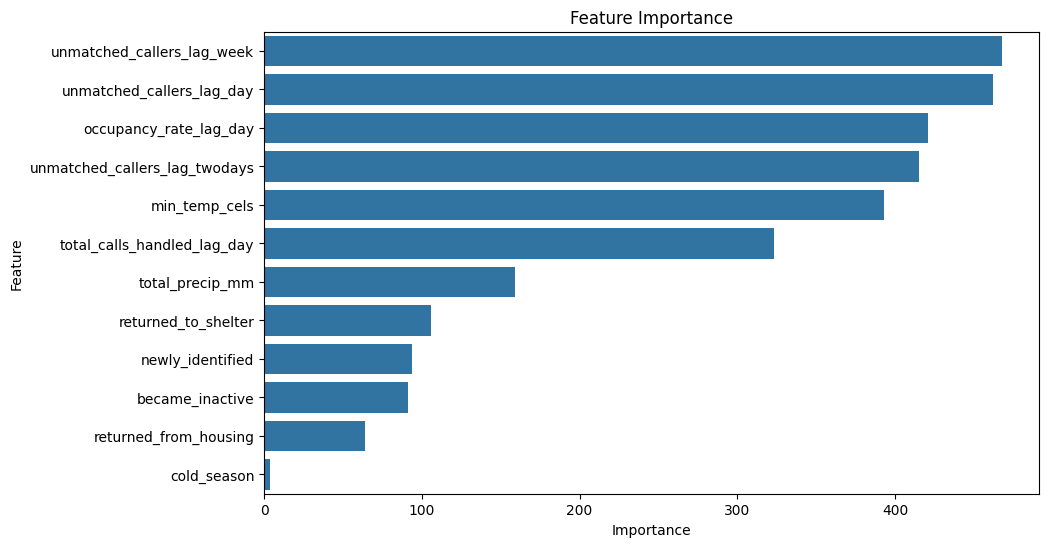

In [655]:
feature_importances = model_lgbm.feature_importances_

feature_names = history_X.columns.tolist()

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Fitting LGBM 

In [656]:
history_X = train_data[['occupancy_rate_lag_day', 'min_temp_cels', 'total_calls_handled_lag_day', 'unmatched_callers_lag_day', 'unmatched_callers_lag_week', 'unmatched_callers_lag_twodays', 'returned_to_shelter']]
history_y = train_data['unmatched_callers'].values 

predictions_lgbm = []
model_lgbm = lgb.LGBMRegressor(verbose=-1)

for t in range(len(test_data)):
    
    model_lgbm.fit(history_X, history_y)
    
    next_row = test_data.iloc[t:t+1]
    next_X = next_row[['occupancy_rate_lag_day', 'min_temp_cels','total_calls_handled_lag_day', 'unmatched_callers_lag_day', 'unmatched_callers_lag_week', 'unmatched_callers_lag_twodays', 'returned_to_shelter']]
    
    yhat = model_lgbm.predict(next_X)[0]
    predictions_lgbm.append(yhat)
    
    true_value = next_row['unmatched_callers'].values[0]
    history_y = np.append(history_y, true_value)
    # Correctly append the next_X row to history_X
    history_X = pd.concat([history_X, next_X], ignore_index=True)

mae_lgbm_rolling = mean_absolute_error(test_data['unmatched_callers'], predictions_lgbm)
print("Mean Absolute Error (MAE) on test data with rolling forecast using LightGBM:", mae_lgbm_rolling)

Mean Absolute Error (MAE) on test data with rolling forecast using LightGBM: 25.694279952264473


# CONCLUSION

* SARIMAX model with two exogenioius variables – min_temp_cel and occupancy_rate_lag_day – yielded the best MAE score compared to LGBM and LinearRegression.

In [33]:
old_unmatched = weather_calls_occupancy_flow_daily.unmatched_callers.to_list()
dump(old_unmatched, 'old_unmatched.joblib')

old_exog = weather_calls_occupancy_flow_daily[current_features].values.tolist()
dump(old_exog, 'old_exog.joblib')


['old_exog.joblib']